In [1]:
import numpy as np

import pandas as pd
import sys, os, time
from scipy.stats import norm
import matplotlib.pyplot as plt

%matplotlib inline

sys.path.append('../..')

In [2]:
from src.data_structures import FactorGraph, PriorityQueue
from src.sampling_algorithms.event_time_samplers import gaussian_bounce
from src.utils import gaussian_grad_potential_fn, interp, get_xtv, get_first_moment, get_second_moment, get_var
from src.sampling_algorithms import LocalBPS
from src.plots.arrow_plot import arrow_plot


In [3]:
dim = 2
num_factors = 3
chain_length = dim * num_factors
factor_indices = np.array([np.array([i +j for j in range(dim)])
                           for i in range(0, dim * num_factors, dim)])

factor_potential_fns = [lambda x: -np.sum(norm.logpdf(x)) for i in range(num_factors)]


Sig = np.diag(np.repeat(1., dim))
mu = np.repeat(0., dim)
bounce_fn = gaussian_bounce(mu, Sig)
bounce_fns = [bounce_fn for i in range(num_factors)]

inv_sig = np.linalg.pinv(Sig)
grad_factor_potential_fns = [lambda x: inv_sig.dot(x-mu) for i in range(num_factors)]

chain_graph = FactorGraph(dim_x=chain_length,
                          factor_indices=factor_indices,
                          factor_potential_fns=factor_potential_fns,
                          grad_factor_potential_fns=grad_factor_potential_fns)



In [4]:
local_bps = LocalBPS(init_x = np.array([np.random.rand() for _ in range(chain_length)]),
         init_v = np.array([np.random.rand() for _ in range(chain_length)]),
         factor_graph = chain_graph,
         bounce_fns=bounce_fns,
         refresh_rate=0.1)

In [5]:
start = time.time()
nsim= 10**5
results = local_bps.simulate(nsim)
res = results
print(time.time()-start)

10.379063606262207


In [6]:
x1,v1,t1=get_xtv(res,0)
x2,v2,t2=get_xtv(res,1)

x = interp(x1,t1,v1, num_intervals=nsim*5)
y = interp(x2,t2,v2, num_intervals=nsim*5)


In [7]:
print(get_first_moment(x1, v1, t1))
print(get_var(x1, v1, t1))

-0.00082661685441227
1.0104643667974391


In [8]:
print(np.mean(x))
print(np.cov(x,y))

print(np.mean((x-np.mean(x))**4))
print(np.mean((y-np.mean(y))**4))

-0.0008294253319955312
[[1.01046678 0.00509043]
 [0.00509043 1.00049754]]
3.118102186995893
3.0049510878512025


In [9]:
x1,v1,t1=get_xtv(res,0)
x2,v2,t2=get_xtv(res,1)

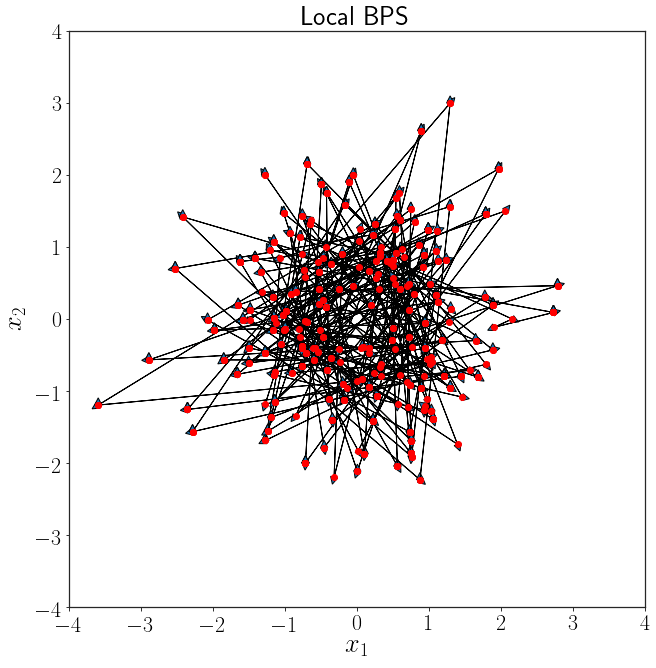

In [15]:
plot_limit = 500
fig_size = (10,10)
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25

font = {
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)


fig = plt.figure(figsize=fig_size,frameon =True)
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height])
ax.set_title("Local BPS")
ax.set_xlabel("$x_1$",fontsize='large', fontweight='bold')
ax.set_ylabel("$x_2$",fontsize='large', fontweight='bold')
ax.set_xlim((-4,4))
ax.set_ylim((-4,4))
arrow_plot(x1[:plot_limit],x2[:plot_limit])
fig.savefig('./local_bps.eps', format='eps', dpi=1200)

